In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('Data', 'Images')
number_images = 59

In [ ]:
!labelme

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
images = tf.data.Dataset.list_files(['Data\\Images\\*.jpg', 'Data\\Images\\*.jpeg'], shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

b'Data\\Images\\IMG_1206.JPEG'

In [86]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [87]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [88]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [ ]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

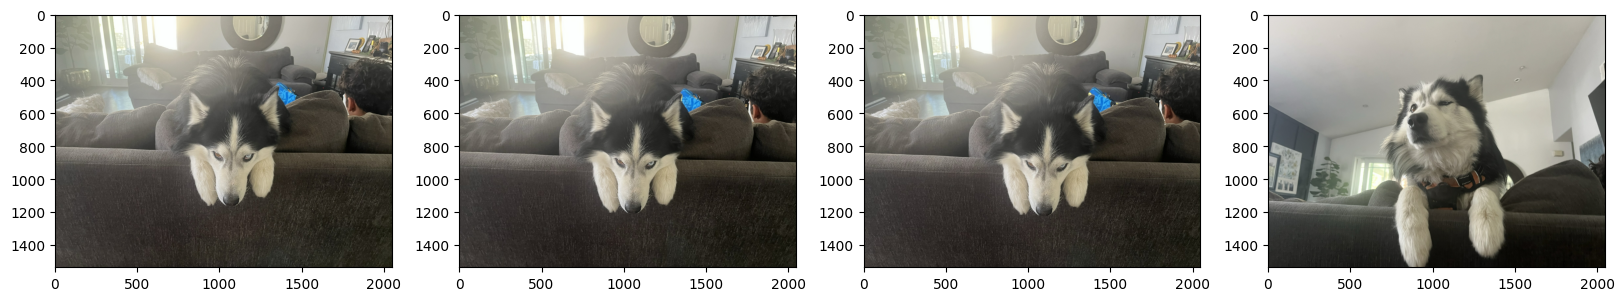

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [ ]:
for folder in ['Train','Test','Val']:
    for file in os.listdir(os.path.join('Data', folder, 'Images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('Data','Labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('Data',folder,'Labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [18]:
img = cv2.imread(os.path.join('Data','Train', 'Images','IMG_1138.JPEG'))

In [19]:
img

array([[[134, 162, 169],
        [132, 160, 167],
        [120, 147, 157],
        ...,
        [153, 167, 173],
        [149, 165, 171],
        [149, 165, 171]],

       [[137, 165, 172],
        [151, 179, 186],
        [173, 200, 210],
        ...,
        [151, 165, 171],
        [148, 164, 170],
        [147, 163, 169]],

       [[191, 220, 229],
        [206, 235, 244],
        [219, 248, 255],
        ...,
        [146, 162, 168],
        [145, 161, 167],
        [143, 159, 165]],

       ...,

       [[168, 152, 139],
        [169, 153, 140],
        [169, 153, 140],
        ...,
        [131, 133, 133],
        [125, 126, 124],
        [114, 115, 113]],

       [[168, 152, 139],
        [168, 152, 139],
        [168, 152, 139],
        ...,
        [125, 127, 127],
        [118, 118, 118],
        [115, 115, 115]],

       [[166, 150, 137],
        [167, 151, 138],
        [167, 151, 138],
        ...,
        [119, 121, 121],
        [124, 124, 124],
        [125, 125, 125]]

In [20]:
height, width, channels = img.shape

In [21]:
print(f"Height: {height}, Width: {width}")

Height: 1536, Width: 2048


In [22]:
with open(os.path.join('Data','Train', 'Labels','IMG_1138.json'), 'r') as f:
    label = json.load(f)

In [23]:
label['shapes'][0]['points']

[[442.47826086956525, 578.8695652173914], [949.0, 1087.5652173913045]]

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[442.47826086956525, 578.8695652173914, 949.0, 1087.5652173913045]

In [26]:
coords = list(np.divide(coords, [width,height,width,height]))

In [27]:
coords

[0.2160538383152174, 0.3768682065217392, 0.46337890625, 0.7080502717391305]

In [28]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Bowie'])

In [29]:
augmented['bboxes'][0][2:]

(0.5389371980676327, 1.0)

In [30]:
augmented['bboxes']

[(0.0, 0.7597101449275364, 0.5389371980676327, 1.0)]

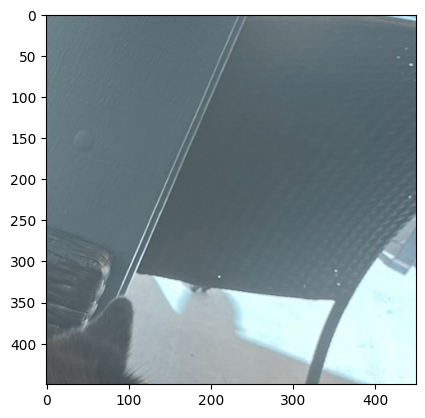

In [31]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [width,height]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [width,height]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])
plt.show()

In [ ]:
for partition in ['Train','Test','Val']: 
    for image in os.listdir(os.path.join('Data', partition, 'Images')):
        img = cv2.imread(os.path.join('Data', partition, 'Images', image))
        
        height, width, channels = img.shape
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('Data', partition, 'Labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [width,height,width,height]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Bowie'])
                cv2.imwrite(os.path.join('aug_data', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


In [11]:
train_images = tf.data.Dataset.list_files(['aug_data\\Train\\Images\\*.jpg','aug_data\\Train\\Images\\*.jpeg'], shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (w,h)))
train_images = train_images.map(lambda x: x/255)

In [12]:
test_images = tf.data.Dataset.list_files(['aug_data\\Test\\Images\\*.jpg','aug_data\\Test\\Images\\*.jpeg'], shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (w,h)))
test_images = test_images.map(lambda x: x/255)

In [13]:
val_images = tf.data.Dataset.list_files(['aug_data\\Val\\Images\\*.jpg','aug_data\\Val\\Images\\*.jpeg'], shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (w,h)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.32438725, 0.39889705, 0.5636029 ],
        [0.30067402, 0.375     , 0.5387255 ],
        [0.3148897 , 0.38106617, 0.53155637],
        ...,
        [0.816299  , 0.7692402 , 0.67512256],
        [0.8442402 , 0.79718137, 0.7099265 ],
        [0.9044118 , 0.860723  , 0.7716912 ]],

       [[0.3272059 , 0.40232843, 0.5675245 ],
        [0.33639705, 0.40392157, 0.5721201 ],
        [0.32794118, 0.3867647 , 0.5397059 ],
        ...,
        [0.7792892 , 0.73223037, 0.6381127 ],
        [0.8382353 , 0.7911765 , 0.70392156],
        [0.83835787, 0.79558825, 0.70226717]],

       [[0.3518995 , 0.43425244, 0.6034926 ],
        [0.31605393, 0.40042892, 0.5625613 ],
        [0.35281864, 0.42340687, 0.5734069 ],
        ...,
        [0.8009804 , 0.75392157, 0.6598039 ],
        [0.8195466 , 0.77248776, 0.6852328 ],
        [0.82028186, 0.7710784 , 0.69123775]],

       ...,

       [[0.8299632 , 0.7907475 , 0.7485907 ],
        [0.6908701 , 0.66047794, 0.60900736],
        [0.77297795, 0

In [14]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [15]:
train_labels = tf.data.Dataset.list_files('aug_data\\Train\\Labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
test_labels = tf.data.Dataset.list_files('aug_data\\Test\\Labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
val_labels = tf.data.Dataset.list_files('aug_data\\Val\\Labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7140, 7140, 1920, 1920, 960, 960)

In [19]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

In [20]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(32)
test = test.prefetch(4)

In [21]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(32)
val = val.prefetch(4)

In [22]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3489 , 0.     , 1.     , 0.6704 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2329 , 0.4004 , 1.     , 1.     ],
        [0.     , 0.     , 1.     , 0.658  ],
        [0.     , 0.     , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.913  , 0.695  , 1.     , 1.     ],
        [0.5864 , 0.597  , 1.     , 1.     ],
        [0.     , 0.1526 , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     ,

In [31]:
data_samples = train.as_numpy_iterator()

In [32]:
res = data_samples.next()

In [33]:
h,w = 120, 120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


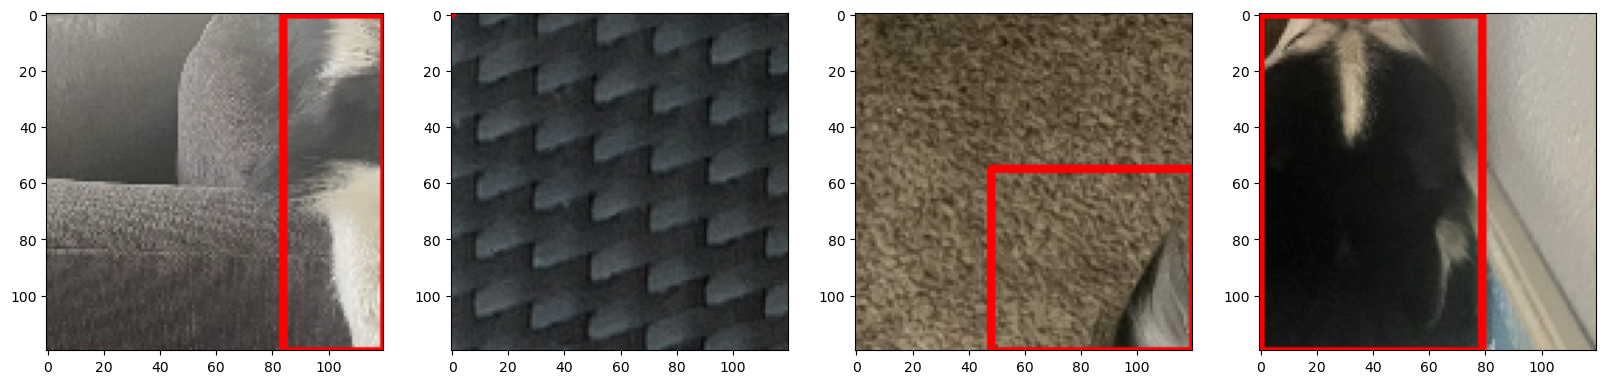

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [w,h]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [w,h]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [36]:
vgg = VGG16(include_top=False)

In [37]:
def build_model(): 
    input_layer = Input(shape=(w,h,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [38]:
bowietracker = build_model()

In [39]:
bowietracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [40]:
X, y = train.as_numpy_iterator().next()

In [41]:
X.shape

(32, 120, 120, 3)

In [42]:
classes, coords = bowietracker.predict(X)

In [43]:
classes, coords

(array([[0.6043565 ],
        [0.4912877 ],
        [0.50667953],
        [0.56409246],
        [0.5970386 ],
        [0.5288753 ],
        [0.53896976],
        [0.4943399 ],
        [0.5366063 ],
        [0.4504469 ],
        [0.51145416],
        [0.6024459 ],
        [0.5984172 ],
        [0.5776409 ],
        [0.5904607 ],
        [0.5653777 ],
        [0.5536919 ],
        [0.6018076 ],
        [0.50409627],
        [0.5644749 ],
        [0.58517003],
        [0.55220664],
        [0.68790275],
        [0.5843627 ],
        [0.5908609 ],
        [0.6582404 ],
        [0.5137514 ],
        [0.6088501 ],
        [0.6032901 ],
        [0.54112685],
        [0.6457213 ],
        [0.5910309 ]], dtype=float32),
 array([[0.3451263 , 0.3984078 , 0.46920937, 0.5695656 ],
        [0.31193665, 0.39459988, 0.42116374, 0.5895553 ],
        [0.42507893, 0.4724156 , 0.4438277 , 0.56019485],
        [0.36582893, 0.4214212 , 0.43479186, 0.520522  ],
        [0.34354812, 0.4683312 , 0.46846333, 0.

In [44]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [46]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [47]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [48]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=27.745255>

In [49]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.68021214>

In [50]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=27.745255>

In [51]:
class BowieTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [52]:
model = BowieTracker(bowietracker)

In [53]:
model.compile(opt, classloss, regressloss)

In [54]:
logdir='logs'

In [55]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [123]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
224/224 [==============================] - 35s 82ms/step - total_loss: 0.1937 - class_loss: 0.0142 - regress_loss: 0.1866 - val_total_loss: 2.4394 - val_class_loss: 0.3877 - val_regress_loss: 2.2456
Epoch 2/5
224/224 [==============================] - 18s 63ms/step - total_loss: 0.1968 - class_loss: 0.0144 - regress_loss: 0.1896 - val_total_loss: 3.0387 - val_class_loss: 0.5341 - val_regress_loss: 2.7717
Epoch 3/5
224/224 [==============================] - 19s 62ms/step - total_loss: 0.1653 - class_loss: 0.0118 - regress_loss: 0.1594 - val_total_loss: 5.0781 - val_class_loss: 1.0932 - val_regress_loss: 4.5315
Epoch 4/5
224/224 [==============================] - 18s 61ms/step - total_loss: 0.1763 - class_loss: 0.0121 - regress_loss: 0.1703 - val_total_loss: 5.0807 - val_class_loss: 0.6352 - val_regress_loss: 4.7631
Epoch 5/5
224/224 [==============================] - 18s 61ms/step - total_loss: 0.1676 - class_loss: 0.0110 - regress_loss: 0.1621 - val_total_loss: 2.2143 - val_c

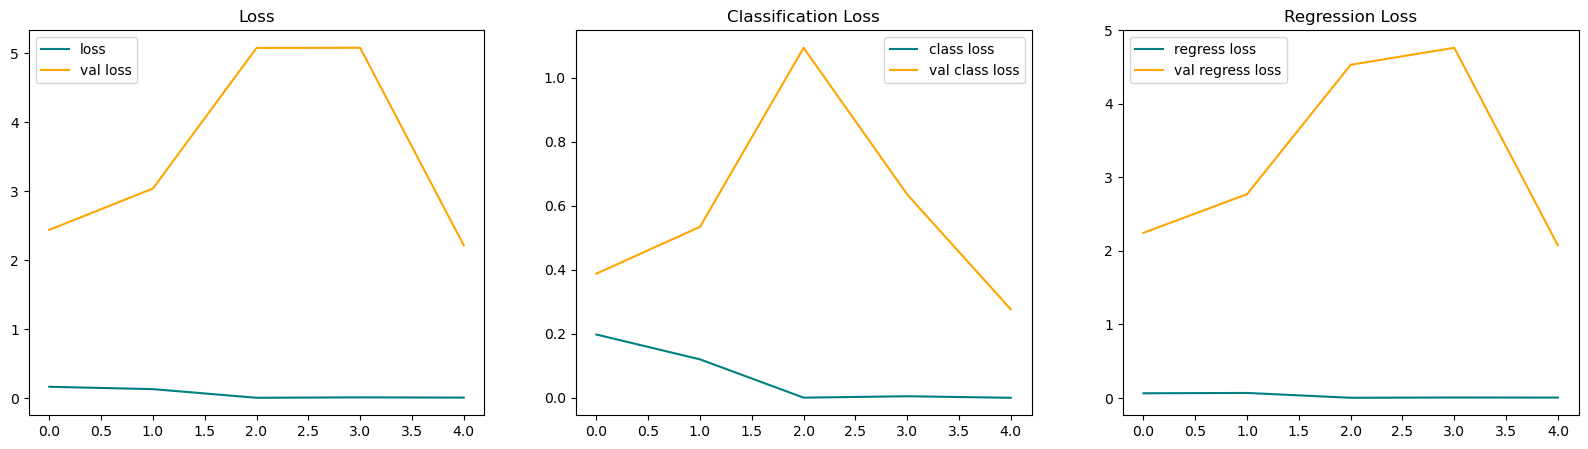

In [124]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [125]:
test_data = test.as_numpy_iterator()

In [126]:
test_sample = test_data.next()

In [127]:
yhat = bowietracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


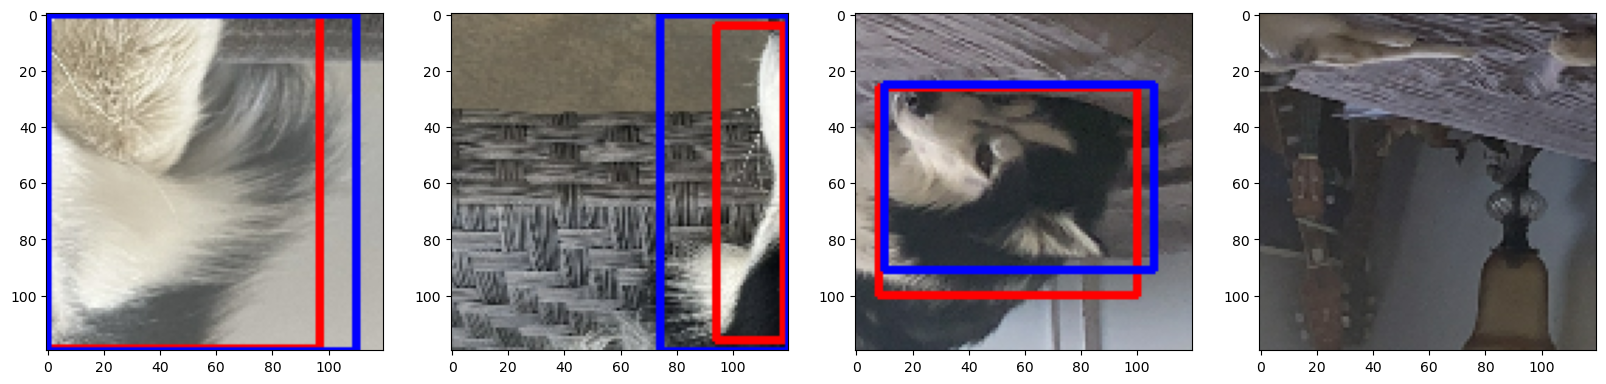

In [128]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    pred_coords = yhat[1][idx]
    true_coords = test_sample[1][1][idx]
    
    if yhat[0][idx] > 0.9:
        # Draw predicted bounding box in blue
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(pred_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(pred_coords[2:], [w,h]).astype(int)), 
                            (255,0,0), 2)
        
        # Draw true bounding box in red
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(true_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(true_coords[2:], [w,h]).astype(int)), 
                            (0,0,255), 2)
    
    ax[idx].imshow(sample_image)

In [131]:
from tensorflow.keras.models import load_model
from IPython.display import clear_output

In [97]:
bowietracker.save('bowietracker.h5')

In [7]:
bowietracker = load_model('bowietracker.h5')

In [132]:
cap = cv2.VideoCapture(1)

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from the camera. Exiting.")
            break

        frame = frame[50:500, 50:500, :]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = tf.image.resize(rgb, (120, 120))

        yhat = bowietracker.predict(np.expand_dims(resized / 255, 0))
        sample_coords = yhat[1][0]

        if yhat[0] > 0.95:
            # Controls the main rectangle
            cv2.rectangle(frame,
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                          (255, 0, 0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame,
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                       [0, -30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                       [80, 0])),
                          (255, 0, 0), -1)

            # Controls the text rendered
            cv2.putText(frame, 'Bowie', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                   [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the frame in Jupyter Lab or Jupyter Notebook
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Press 'q' to quit
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
finally:
    cap.release()
    # cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
!pip install opencv-python

In [98]:
#tests
test_images2 = tf.data.Dataset.list_files(['Other\\*.jpg','Other\\*.jpeg'], shuffle=False)
test_images2 = test_images2.map(load_image)
test_images2 = test_images2.map(lambda x: tf.image.resize(x, (w,h)))
test_images2 = test_images2.map(lambda x: x/255)


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [w,h]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)